In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from mne.viz import circular_layout, plot_connectivity_circle
import copy
import os

# Import and prepare data for circular viz

In [7]:
# Two versions of the same data

## full_data includes the dataset with photo information, datetime, location, etc.
## 
full_data = pd.read_csv(os.path.join("data", "gnomon_data.csv"))
full_data["Datetime"] = pd.to_datetime(full_data["Datetime"])

data = pd.read_csv(os.path.join("data", "adjacency_matrix.csv")).values

In [8]:
def getcluster(dfMat, cluster):
    """
    Takes as arguments a data matrix and an integer (which represents the cluster
    number you are trying to isolate). Returns a data matrix with only that cluster
    represented. All other clusters are set to null (no relationship).
    """
    newDFMat = copy.copy(dfMat)
    for i in range(newDFMat.shape[0]):
        for j in range(newDFMat.shape[1]):
            if newDFMat[i, j] != cluster:
                newDFMat[i,j] = np.nan
    return newDFMat

def changeZero(dfMat):
    """
    Takes a data matrix and converts the zeros to null values. This is necessary
    because the circular chart represents a relationship of 0 as a low-strength 
    connection.
    """
    newDFMat = copy.copy(dfMat)
    for i in range(newDFMat.shape[0]):
        for j in range(newDFMat.shape[1]):
            if newDFMat[i, j] == 0:
                newDFMat[i,j] = np.nan
    return newDFMat

def getTimeDiffs(df, day):
    """
    Takes a dataframe and a day (as string) and returns a list of the differences in
    time in seconds between each photograph taken on that day.
    """
    diffs_L = [0]
    
    # Store the first value
    prev_dt = df[df["Day"] == day]["Datetime"].iloc[0]

    # Now iterate through all datetimes of a specific day and find time b/t photos
    for dt in df[df["Day"] == day]["Datetime"].values[1:]:
        diff = pd.to_datetime(dt) - prev_dt
        diffs_L.append(diff.seconds - (3*60))
        
        # Store the current datetime before moving on
        prev_dt = dt
        
    diffs_L = np.array(diffs_L)
    # Normalize array between -2 and 2
    diffs_L = 2.5 * (diffs_L / diffs_L.max())
    
    return diffs_L

In [9]:
# Change the zeros to nan 
data = changeZero(data)

# Make a list of clusters 0 to 5. The index of this list represents the cluster #
# Cluster 0 represents the set of all clusters
clust = [data] + [getcluster(data, i) for i in range(1, 6)]

In [10]:
# Set the colors of the nodes, which represent the locations of the photographs

locations = full_data['Location'].unique()
n_locations = full_data['Location'].unique().shape[0]
cmap = matplotlib.cm.get_cmap('viridis')

loc_colors  = dict()

for i in range(n_locations):
    loc_colors[locations[i]] = cmap(i / n_locations)
    
node_colors = [loc_colors[i] for i in full_data['Location'].values]

# Plot the data

- Cluster is a variable that can be changed to represent the cluster you want to represent
- Cluster 0 shows all clusters

C:\Users\colef\AppData\Local\Continuum\anaconda3\lib\site-packages\mne\viz\circle.py:309: RuntimeWarning: invalid value encountered in greater_equal
  con_draw_idx = np.where(con_abs >= con_thresh)[0]


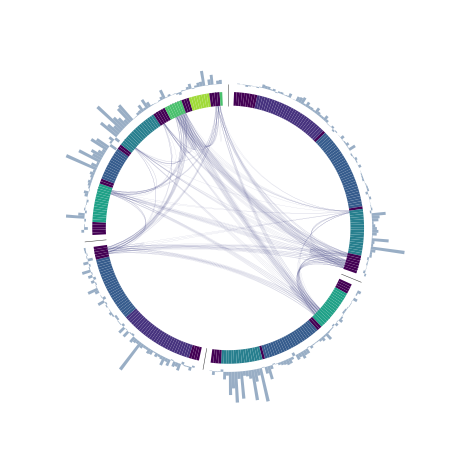

In [11]:

def circ_plot(cluster=0, save=False):
    """
    Plots the circular connectivity graph.
    """
    label_names = [str(i) for i in range(1, data.shape[0]+1)]

    mon_n   = 97
    tues_n  = 66
    wed_n   = 63
    thurs_n = 82
    tot_n   = 308

    # Compute the node angles for plotting
    node_angles = circular_layout(label_names, node_order=label_names, start_pos=-90,
                                  group_boundaries=[0, 
                                                    (mon_n / tot_n)                    * len(label_names), 
                                                    ((mon_n + tues_n) / tot_n)         * len(label_names), 
                                                    ((mon_n + tues_n + wed_n) / tot_n) * len(label_names)], 
                                  group_sep=5, start_between=True)

    # Plot the connectivity circle
    fig, ax = plot_connectivity_circle(clust[cluster], 
                                       node_names=["" for i in range(len(label_names))], 
                                       node_linewidth=0.01,
                                       node_colors=node_colors, 
                                       node_edgecolor='white',
                                       vmin=0, 
                                       vmax=5,
                                       node_angles=node_angles, 
                                       colormap='viridis', 
                                       linewidth=0.05, 
                                       facecolor='white', 
                                       colorbar=False, 
                                       show=False)

    
    # Add lines between the separations between week days
    start = -np.pi/2
    second = start + (mon_n / tot_n) * 2 * np.pi - 0.02
    third = start + ((mon_n + tues_n) / tot_n) * 2 * np.pi - 0.008
    fourth = start + ((mon_n + tues_n + wed_n) / tot_n) * 2 * np.pi + 0.004

    ymax = 10.6
    alpha = 0.8
    width = 0.5

    plt.vlines(start, ymin=9, ymax=ymax, alpha=alpha, linewidth=width, color='black')
    plt.vlines(second, ymin=9, ymax=ymax, alpha=alpha, linewidth=width, color='black')
    plt.vlines(third, ymin=9, ymax=ymax, alpha=alpha, linewidth=width, color='black')
    plt.vlines(fourth, ymin=9, ymax=ymax, alpha=alpha, linewidth=width, color='black')

    # Reverse the direction of the axis object
    ax.set_theta_direction(-1)
    
    
    
    
    
    # NOW MAKE THE BAR PLOTS ON THE OUTSIDE OF THE NODES
    
    bottom = 10.6
    N = tot_n
    node_width = (2*np.pi) / (tot_n + (5 * 4)) - 0.00009 # there are 4 spaces of 5 nodes separating the days (-0.00008 works)
    
    
    
    # Monday first
    
    mon_start =  (-np.pi / 2) + (node_width * 2.5) + 0.0055 # Monday begins at this position mon_start
    
    mon_theta = np.linspace(mon_start, 
                            mon_start + (node_width * mon_n), 
                            mon_n) # These are X positions for each plot
    mon_radii = getTimeDiffs(full_data, 'monday') # These are the heights of the bars
    mon_width = [node_width for i in range(mon_n)]
    mon_bottoms = [bottom for i in range(mon_n)]
    bars = ax.bar(mon_theta, 
                  mon_radii, 
                  bottom=mon_bottoms, 
                  width=mon_width,
                  color=cmap(0.3))

    for r, bar in zip(mon_radii, bars):
#         bar.set_facecolor(plt.cm.viridis(r / 2.))
        bar.set_alpha(0.5)
    
    # Ticks for the hours
#     for pics in [12, 27, 41, 57, 75, 85, ]:
#         plt.vlines(mon_start + (node_width * pics), ymin=10, ymax=10.15, 
#                    alpha=0.65, linewidth=width, color='black')
        
        
        
        
        
    # Tuesday plots now
        
    tues_start = mon_start + (node_width * mon_n) + (node_width * 5) + 0.0116 # First node of Tuesday
    node_width = (2*np.pi) / (tot_n + (5 * 4)) - 0.00018

    tues_theta = np.linspace(tues_start, 
                             tues_start + (node_width * tues_n), 
                             tues_n) # These are X positions for each plot
    tues_radii = getTimeDiffs(full_data, 'tuesday') # These are the heights of the bars
    tues_width = [node_width for i in range(tues_n)]
    tues_bottoms = [bottom for i in range(tues_n)]
    bars = ax.bar(tues_theta, 
                  tues_radii, 
                  bottom=tues_bottoms, 
                  width=tues_width,
                  color=cmap(0.3))

    for r, bar in zip(tues_radii, bars):
#         bar.set_facecolor(plt.cm.viridis(r / 2.))
        bar.set_alpha(0.5)
        
        
        
        
        
    # Wednesday plots now
        
    weds_start = tues_start + (node_width * tues_n) + (node_width * 5) + 0.0112 # First node of Wednesday
    node_width = (2*np.pi) / (tot_n + (5 * 4)) - 0.00018

    weds_theta = np.linspace(weds_start, 
                             weds_start + (node_width * wed_n), 
                             wed_n) # These are X positions for each plot
    weds_radii = getTimeDiffs(full_data, 'wednesday') # These are the heights of the bars
    weds_width = [node_width for i in range(wed_n)]
    weds_bottoms = [bottom for i in range(wed_n)]
    bars = ax.bar(weds_theta, 
                  weds_radii, 
                  bottom=weds_bottoms, 
                  width=weds_width,
                  color=cmap(0.3))

    for r, bar in zip(weds_radii, bars):
#         bar.set_facecolor(plt.cm.viridis(r / 2.))
        bar.set_alpha(0.5)
    
    
    
    
    
    # Thursday plots now
        
    thur_start = weds_start + (node_width * wed_n) + (node_width * 5) + 0.0112 # First node of Wednesday
    node_width = (2*np.pi) / (tot_n + (5 * 4)) - 0.000125

    thur_theta = np.linspace(thur_start, 
                             thur_start + (node_width * thurs_n), 
                             thurs_n) # These are X positions for each plot
    thur_radii = getTimeDiffs(full_data, 'thursday') # These are the heights of the bars
    thur_width = [node_width for i in range(thurs_n)]
    thur_bottoms = [bottom for i in range(thurs_n)]
    bars = ax.bar(thur_theta, 
                  thur_radii, 
                  bottom=thur_bottoms, 
                  width=thur_width,
                  color=cmap(0.3))

    for r, bar in zip(thur_radii, bars):
#         bar.set_facecolor(plt.cm.viridis(r / 2.))
        bar.set_alpha(0.5)
    
    
    # Save file if argument says so
    if save == True:
        plt.savefig('chorddiag_clust%d.png' % (cluster), dpi=750, bbox_inches='tight')
        

cluster = 1
circ_plot(cluster=cluster, save=False)
# circ_plot(cluster=cluster, save=True)

# for i in range(6):
#     circ_plot(cluster=i, save=True)
